In [1]:
!git clone https://github.com/duyet/vietnamese-wordlist.git

Cloning into 'vietnamese-wordlist'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 55 (delta 0), reused 1 (delta 0), pack-reused 52 (from 1)
Receiving objects: 100% (55/55), 650.75 KiB | 20.34 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [2]:
from datasets import load_dataset
from statistics import mode
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

In [3]:
ds = load_dataset("nam194/vietnews")

README.md:   0%|          | 0.00/748 [00:00<?, ?B/s]

(…)-00000-of-00001-84acb79f6c6547a5.parquet:   0%|          | 0.00/170M [00:00<?, ?B/s]

(…)-00000-of-00001-210cc51bf3cdb90f.parquet:   0%|          | 0.00/38.3M [00:00<?, ?B/s]

(…)-00000-of-00001-123f98d55067eb7b.parquet:   0%|          | 0.00/38.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/99134 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/22184 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22498 [00:00<?, ? examples/s]

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['guid', 'title', 'abstract', 'article'],
        num_rows: 99134
    })
    validation: Dataset({
        features: ['guid', 'title', 'abstract', 'article'],
        num_rows: 22184
    })
    test: Dataset({
        features: ['guid', 'title', 'abstract', 'article'],
        num_rows: 22498
    })
})

In [5]:
ds['train'][0]

{'guid': 1,
 'title': 'Khởi_tố kẻ_trộm hơn 1 tạ thóc và hơn 8 triệu đồng của chú ruột để lấy tiền mua ma_tuý',
 'abstract': 'Với bản_tính ham chơi , lười làm , có nhiều tiền_án tiền_sự , lại nghiện ma_tuý , Thương đã đột_nhập vào nhà chú ruột để trộm hơn 1 tạ thóc và hơn 8 triệu đồng mang đi tiêu_xài .',
 'article': 'Ngày 27/3 , Cơ_quan Cảnh_sát điều_tra Công_an TP. Hưng_Yên , tỉnh Hưng_Yên cho biết , đơn_vị vừa ra quyết_định khởi_tố vụ án , khởi_tố bị_can đối_với đối_tượng Mai_Văn_Thương ( SN 1989 , trú tại đội 11 , thôn An_Chiểu 1 , xã Liên_Phương , TP. Hưng_Yên ) để điều_tra về hành_vi trộm_cắp tài_sản . Theo tài_liệu điều_tra của cơ_quan công_an , vào_khoảng 7h30 ngày 13/3 , lợi_dụng gia_đình ông Mai_Văn_Thịnh ( chú ruột đối_tượng Thương ) ở cạnh nhà đi vắng , đối_tượng này đã đạp gãy chấn_song cửa_sổ , đột_nhập vào nhà ông Thịnh trộm_cắp 121kg thóc mang bán cho người cùng thôn lấy 700.000 đ . Không dừng lại , sau đó đối_tượng tiếp_tục quay lại lục_soát tủ nhà ông Thịnh trộm_cắp 8.

In [6]:
ds = ds.remove_columns(['guid', 'title'])
ds

DatasetDict({
    train: Dataset({
        features: ['abstract', 'article'],
        num_rows: 99134
    })
    validation: Dataset({
        features: ['abstract', 'article'],
        num_rows: 22184
    })
    test: Dataset({
        features: ['abstract', 'article'],
        num_rows: 22498
    })
})

In [7]:
def add_token(ds):
    return {'abstract': [f'<sos> {seq} <eos>' for seq in ds['abstract']]}

In [8]:
ds = ds.map(add_token, batched=True)

Map:   0%|          | 0/99134 [00:00<?, ? examples/s]

Map:   0%|          | 0/22184 [00:00<?, ? examples/s]

Map:   0%|          | 0/22498 [00:00<?, ? examples/s]

In [9]:
ds['train']['abstract'][0]

'<sos> Với bản_tính ham chơi , lười làm , có nhiều tiền_án tiền_sự , lại nghiện ma_tuý , Thương đã đột_nhập vào nhà chú ruột để trộm hơn 1 tạ thóc và hơn 8 triệu đồng mang đi tiêu_xài . <eos>'

In [10]:
# !pip install -q sentencepiece

In [11]:
# with open("input_text.txt", "w", encoding="utf-8") as f:
#     for item in ds['train']['article']:
#         f.write(item + "\n")
#     for item in ds['train']['abstract']:
#         f.write(item + "\n")

In [12]:
# import sentencepiece as spm

# spm.SentencePieceTrainer.Train('--input=/kaggle/working/input_text.txt --model_prefix=spm --vocab_size=15000 --model_type=bpe')

In [13]:
# with open('/kaggle/working/vietnamese-wordlist/Viet74K.txt', 'r') as f:
#     vocab = f.read()

In [14]:
# vocab = vocab.split('\n')
# vocab_dict = {word: idx for idx, word in enumerate(vocab, start=4)}
# vocab_dict['<oov>'] = 1
# vocab_dict['<sos>'] = 2
# vocab_dict['<eos>'] = 3
# vocab_size = len(vocab_dict)
# print(vocab_size)

In [15]:
# vocab_dict

In [16]:
tokenizer = Tokenizer(num_words=15000, filters='', lower=False, oov_token='<oov>')
tokenizer.fit_on_texts(ds['train']['abstract'] + ds['train']['article'])

In [17]:
vocab_len = len(tokenizer.word_index)
print(vocab_len)

307070


In [18]:
print(tokenizer.word_index.get('<sos>'))
print(tokenizer.word_index.get('<eos>'))

49
50


In [19]:
# Truy cập từ điển chứa số lần xuất hiện của từng từ
word_counts = tokenizer.word_counts

# Tìm số lần xuất hiện ít nhất
min_count = min(word_counts.values())

# Lấy danh sách các từ xuất hiện ít nhất
least_frequent_words = [word for word, count in word_counts.items() if count == min_count]

# Đếm số lượng từ xuất hiện ít nhất
count_least_frequent = len(least_frequent_words)

print("Số từ xuất hiện 1 lần:", count_least_frequent)

Số từ xuất hiện 1 lần: 146771


In [20]:
def tokenization(ds):
    return {'abstract': tokenizer.texts_to_sequences(ds['abstract']), 'article': tokenizer.texts_to_sequences(ds['article'])}

In [21]:
ds = ds.map(tokenization, batched=True)

Map:   0%|          | 0/99134 [00:00<?, ? examples/s]

Map:   0%|          | 0/22184 [00:00<?, ? examples/s]

Map:   0%|          | 0/22498 [00:00<?, ? examples/s]

In [22]:
max_in_len = max([len(i) for i in ds['train']['article']])
max_tr_len = max([len(i) for i in ds['train']['abstract']])
print(f'Max input len: {max_in_len}')
print(f'Max target len: {max_tr_len}')

Max input len: 2121
Max target len: 125


In [23]:
def padding(ds):
    return {'abstract': pad_sequences(ds['abstract'], maxlen=max_tr_len, padding='post', truncating='post'), 'article': pad_sequences(ds['article'], maxlen=max_in_len, padding='post', truncating='post')}

In [24]:
ds = ds.map(padding, batched=True)

Map:   0%|          | 0/99134 [00:00<?, ? examples/s]

Map:   0%|          | 0/22184 [00:00<?, ? examples/s]

Map:   0%|          | 0/22498 [00:00<?, ? examples/s]

In [25]:
ds = ds.rename_column('article', 'X')
ds

DatasetDict({
    train: Dataset({
        features: ['abstract', 'X'],
        num_rows: 99134
    })
    validation: Dataset({
        features: ['abstract', 'X'],
        num_rows: 22184
    })
    test: Dataset({
        features: ['abstract', 'X'],
        num_rows: 22498
    })
})

In [26]:
ds = ds.map(lambda x: {'y_input': [seq[:-1] for seq in x['abstract']], 'y_output': [seq[1:] for seq in x['abstract']]}, batched=True)
ds = ds.remove_columns(['abstract'])
ds

Map:   0%|          | 0/99134 [00:00<?, ? examples/s]

Map:   0%|          | 0/22184 [00:00<?, ? examples/s]

Map:   0%|          | 0/22498 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['X', 'y_input', 'y_output'],
        num_rows: 99134
    })
    validation: Dataset({
        features: ['X', 'y_input', 'y_output'],
        num_rows: 22184
    })
    test: Dataset({
        features: ['X', 'y_input', 'y_output'],
        num_rows: 22498
    })
})

In [27]:
K.clear_session() 
latent_dim = 500
vocab_len=15000

#create input object of total number of encoder words
en_inputs = Input(shape=(max_in_len,), name='X') 
en_embedding = Embedding(vocab_len+1, latent_dim)(en_inputs)

In [28]:
#create 3 stacked LSTM layer with the shape of hidden dimension for text summarizer using deep learning
#LSTM 1
en_lstm1= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs1, state_h1, state_c1= en_lstm1(en_embedding) 
 
#LSTM2
en_lstm2= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs2, state_h2, state_c2= en_lstm2(en_outputs1) 
 
#LSTM3
en_lstm3= LSTM(latent_dim,return_sequences=True,return_state=True)
en_outputs3 , state_h3 , state_c3= en_lstm3(en_outputs2)
 
#encoder states
en_states= [state_h3, state_c3]

In [29]:
dec_inputs = Input(shape=(None,), name='y_input') 
dec_emb_layer = Embedding(vocab_len+1, latent_dim) 
dec_embedding = dec_emb_layer(dec_inputs) 
 
#initialize decoder's LSTM layer with the output states of encoder
dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_outputs, *_ = dec_lstm(dec_embedding,initial_state=en_states) 

In [30]:
#Attention layer
attention =Attention()
attn_out = attention([dec_outputs,en_outputs3])
 
#Concatenate the attention output with the decoder outputs
merge=Concatenate(axis=-1, name='concat_layer1')([dec_outputs,attn_out])

In [31]:
#Dense layer (output layer)
dec_dense = Dense(vocab_len+1, activation='softmax') 
dec_outputs = dec_dense(merge)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ X (InputLayer)      │ (None, 2121)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 2121, 500) │  7,500,500 │ X[0][0]           │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 2121,     │  2,002,000 │ embedding[0][0]   │
│                     │ 500), (None,      │            │                   │
│                     │ 500), (None,      │            │                   │
│                     │ 500)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y_input             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 2121,     │  2,002,000 │ lstm[0][0]        │
│                     │ 500), (None,      │            │                   │
│                     │ 500), (None,      │            │                   │
│                     │ 500)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 500) │  7,500,500 │ y_input[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 2121,     │  2,002,000 │ lstm_1[0][0]      │
│                     │ 500), (None,      │            │                   │
│                     │ 500), (None,      │            │                   │
│                     │ 500)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │  2,002,000 │ embedding_1[0][0… │
│                     │ 500), (None,      │            │ lstm_2[0][1],     │
│                     │ 500), (None,      │            │ lstm_2[0][2]      │
│                     │ 500)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, None, 500) │          0 │ lstm_3[0][0],     │
│ (Attention)         │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer1       │ (None, None,      │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │ 1000)             │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │ 15,016,001 │ concat_layer1[0]… │
│                     │ 15001)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,025,001 (145.05 MB)

 Trainable params: 38,025,001 (145.05 MB)

 Non-trainable params: 0 (0.00 B)

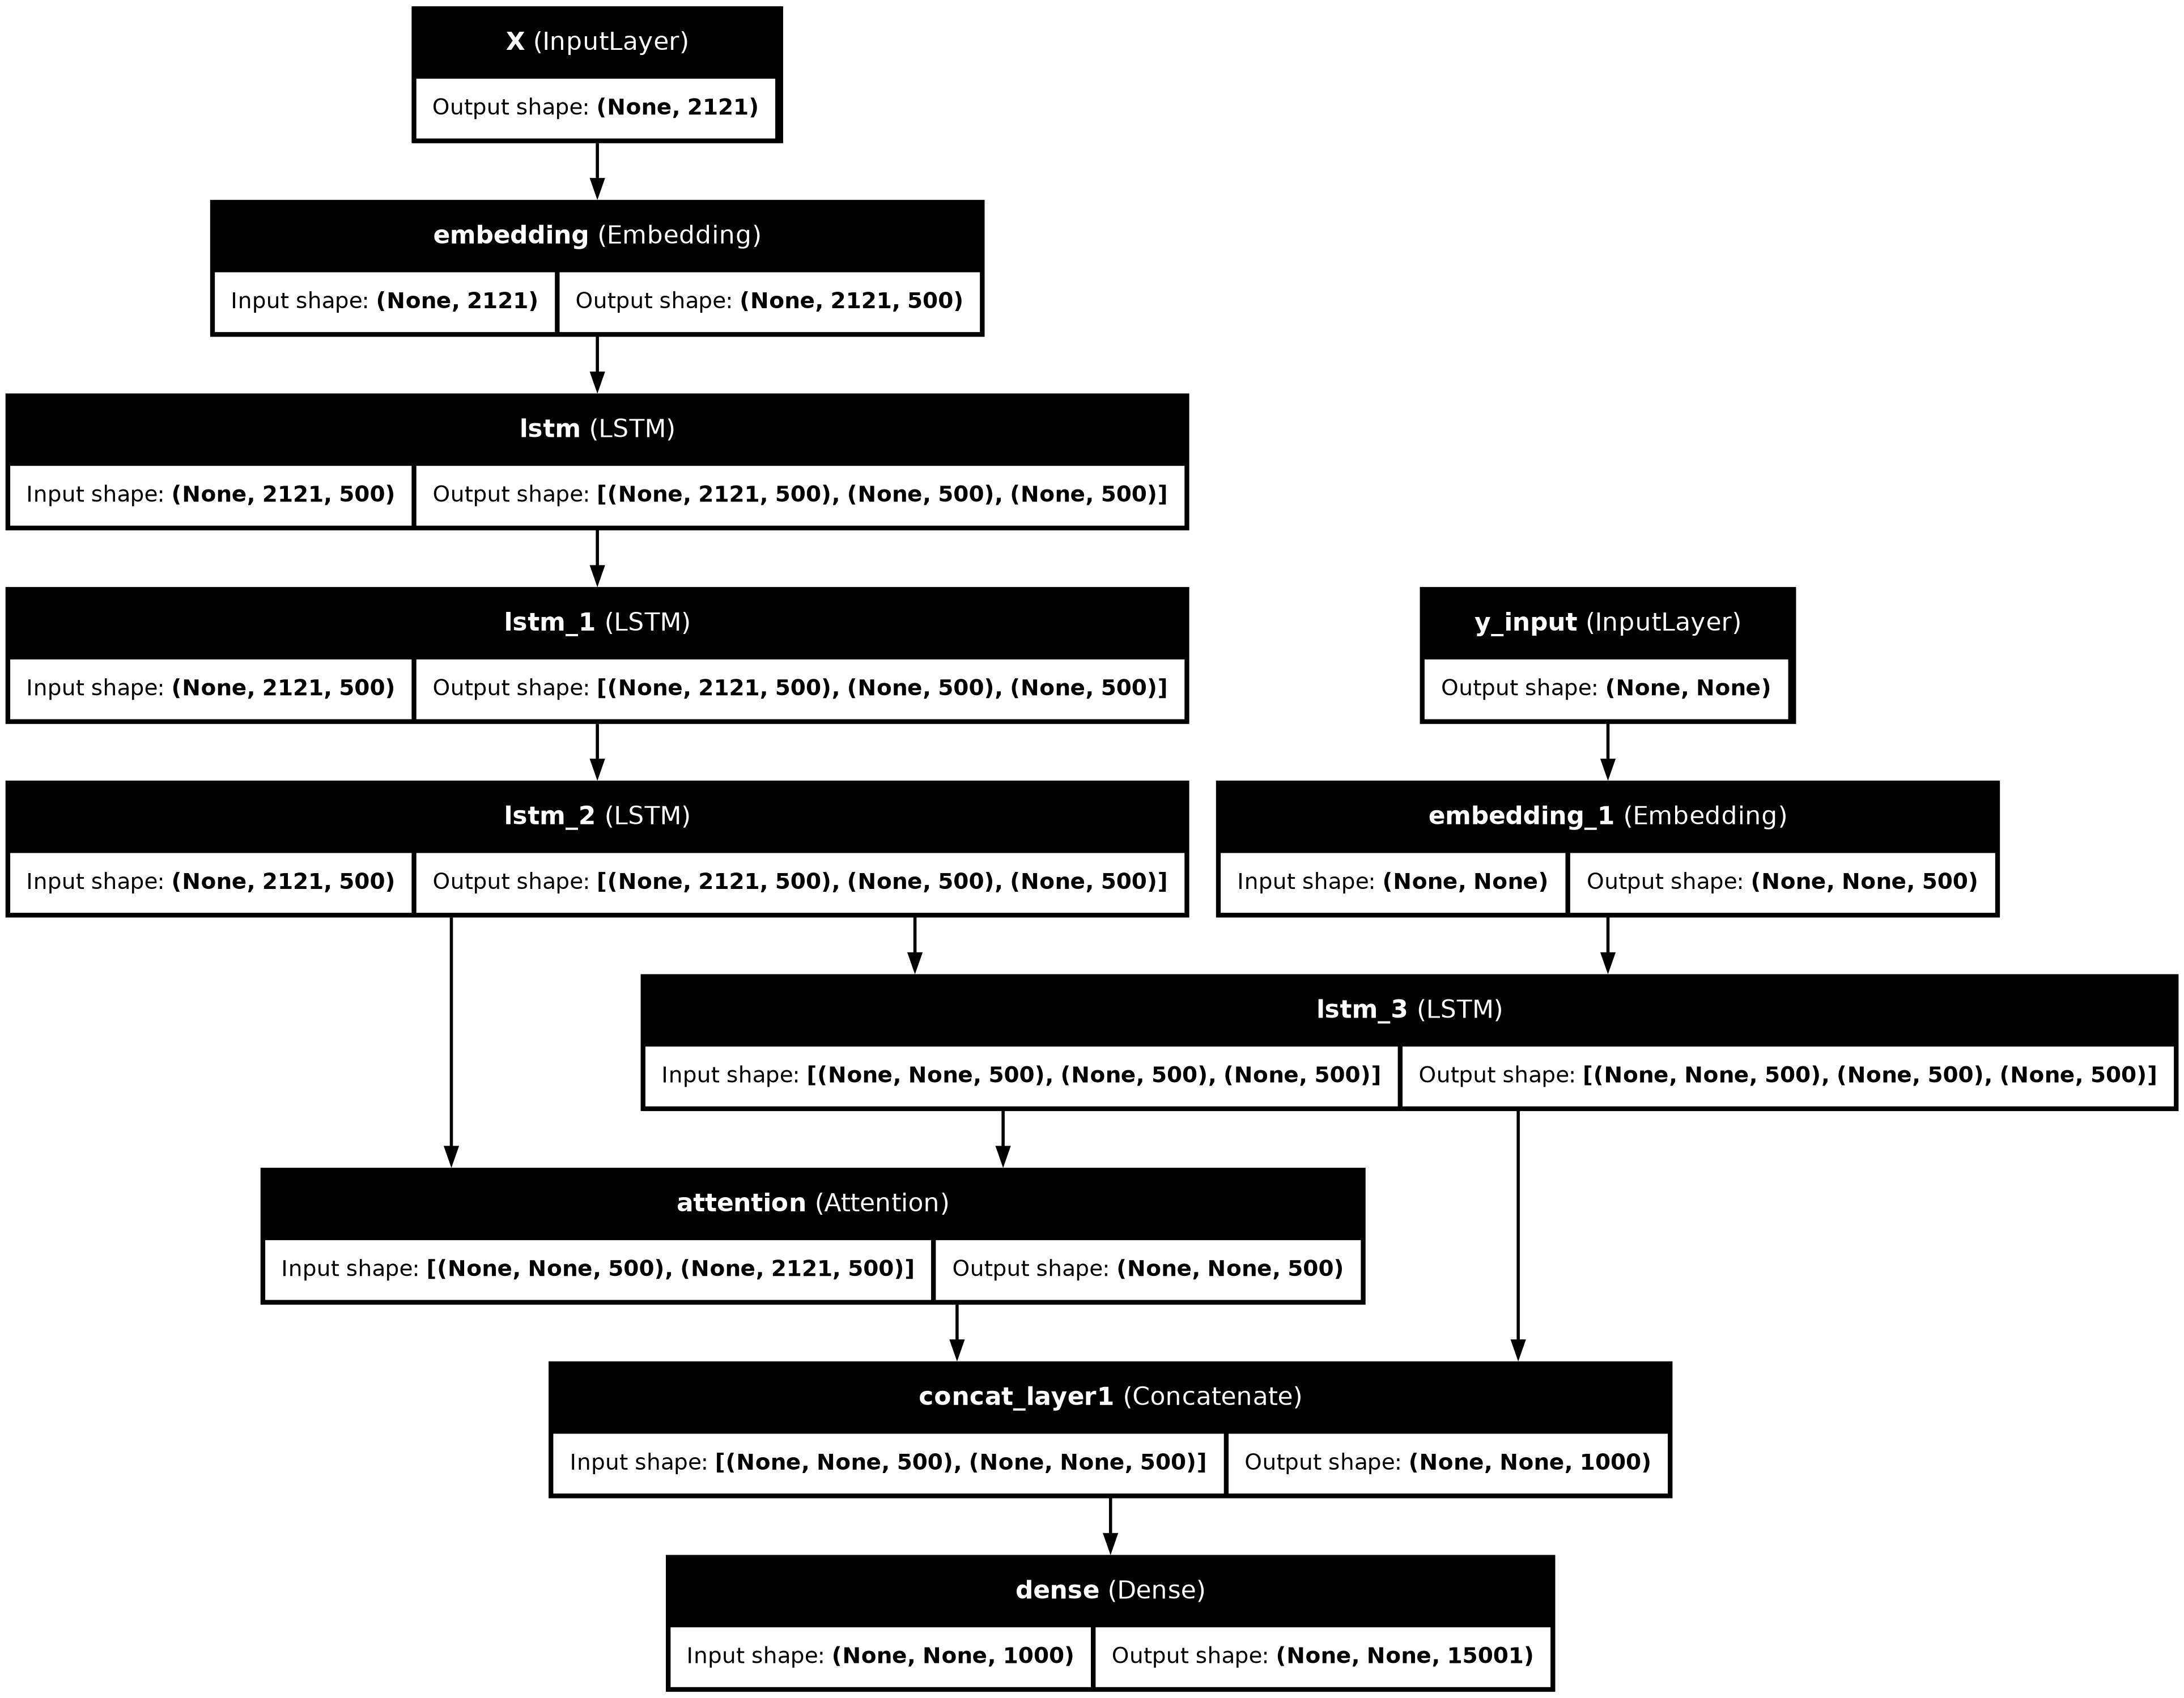

In [32]:
#Model class and model summary for text Summarizer
model = Model([en_inputs, dec_inputs], dec_outputs) 
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [33]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"] ) 

In [34]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=10,
                              min_lr=1e-6,
                              verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               verbose=1)
callbacks = [reduce_lr]

In [35]:
ds = ds.with_format("tf")

In [36]:
X_data = ds['train']['X']
y_input_data = ds['train']['y_input']
y_output_data = ds['train']['y_output']

train_dataset = tf.data.Dataset.from_tensor_slices(((X_data, y_input_data), y_output_data))

train_dataset = train_dataset.batch(64)

In [37]:
X_data = ds['validation']['X']
y_input_data = ds['validation']['y_input']
y_output_data = ds['validation']['y_output']

valid_dataset = tf.data.Dataset.from_tensor_slices(((X_data, y_input_data), y_output_data))

valid_dataset = valid_dataset.batch(64)

In [38]:
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=10,
                    callbacks=callbacks)

Epoch 1/10
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 2486s 2s/step - accuracy: 0.7772 - loss: 1.6840 - val_accuracy: 0.8063 - val_loss: 1.2704 - learning_rate: 0.0010
Epoch 2/10
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 2487s 2s/step - accuracy: 0.8107 - loss: 1.1498 - val_accuracy: 0.8135 - val_loss: 1.1516 - learning_rate: 0.0010
Epoch 3/10
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 2495s 2s/step - accuracy: 0.8189 - loss: 1.0348 - val_accuracy: 0.8168 - val_loss: 1.1103 - learning_rate: 0.0010
Epoch 4/10
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 2493s 2s/step - accuracy: 0.8241 - loss: 0.9681 - val_accuracy: 0.8182 - val_loss: 1.0955 - learning_rate: 0.0010
Epoch 5/10
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 2492s 2s/step - accuracy: 0.8285 - loss: 0.9161 - val_accuracy: 0.8193 - val_loss: 1.0829 - learning_rate: 0.0010
Epoch 6/10
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 2491s 2s/step - accuracy: 0.8327 - loss: 0.8711 - val_accuracy: 0.8196 - val_loss: 1.0840 - learning_rate: 0.0010
Epoch 7/10
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 2493s 2s/step - accura

In [39]:
model.save('./text_summarization_model.h5')

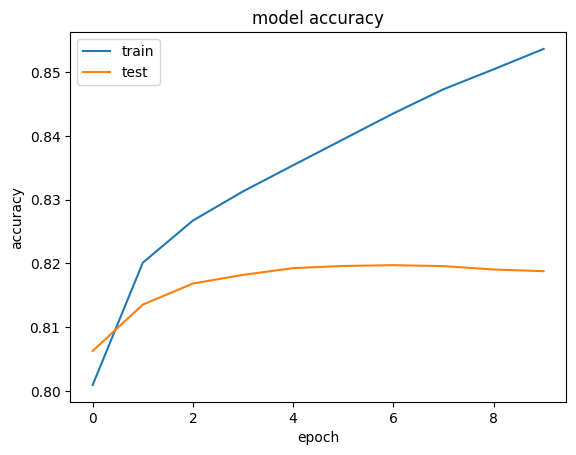

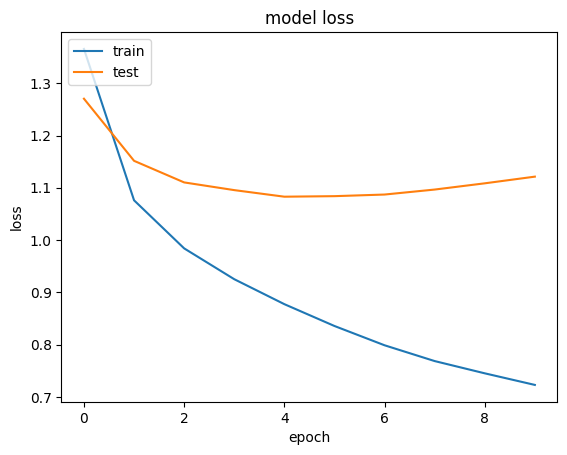

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()